## Diagnóstico por Imágenes - Neumonía

## Importamos las librerías necesarias

In [3]:
# Fuente: https://www.kaggle.com/artemkostrikin/pneumonia-model-cnn-92
# Datasets: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
import os
import numpy as np
import pandas as pd 
import random
import cv2
#pip install --upgrade pip
#pip install opencv-python
import matplotlib.pyplot as plt
%matplotlib inline
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

In [4]:
seed = 232
tf.random.set_seed(
    seed
)

## Imprimimos un ejemplo de ambas condiciones:
### Normal y Pneumonia

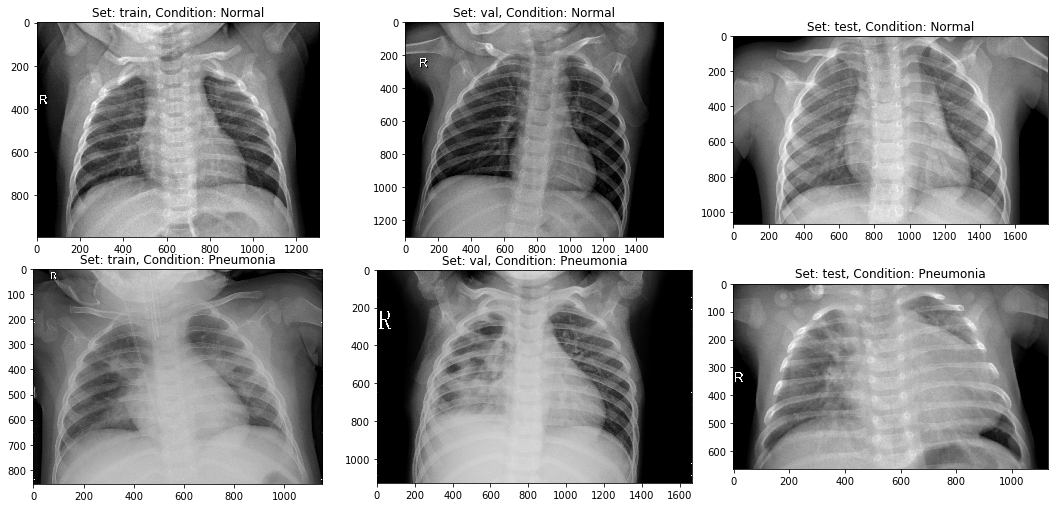

In [5]:
input_path = 'chest_xray/'

fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL') [0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA') [0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))

In [6]:
normal_example = os.listdir(f'{input_path}train/NORMAL')[0]
pneumonia_example = os.listdir(f'{input_path}train/PNEUMONIA')[0]

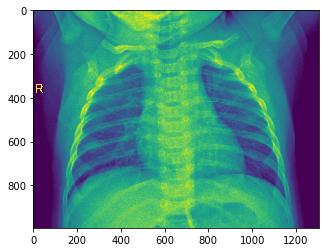

In [7]:
normal_img = plt.imread(f'{input_path}train/NORMAL/{normal_example}')
plt.imshow(normal_img)

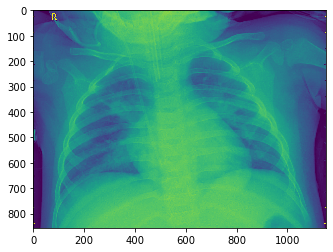

In [8]:
pneumonia_img = plt.imread(f'{input_path}train/PNEUMONIA/{pneumonia_example}')
plt.imshow(pneumonia_img)

## Vemos la distribución de los datasets

In [9]:
for _set in ['train', 'val', 'test']:
    n_normal = len(os.listdir(input_path + _set + '/NORMAL'))
    n_infect = len(os.listdir(input_path + _set + '/PNEUMONIA'))
    print('Set: {}, normal images: {}, pneumonia images: {}'.format(_set, n_normal, n_infect))

Set: train, normal images: 1341, pneumonia images: 3875
Set: val, normal images: 8, pneumonia images: 8
Set: test, normal images: 234, pneumonia images: 390


## Definimos la función con la que vamos a procesar los datasets

In [10]:
def process_data(img_dims, batch_size):
    # Data generation objects
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    test_val_datagen = ImageDataGenerator(rescale=1./255)
    
    # Esto alimenta a la red en los tamaños de lote y dimensiones de imagen especificados.
    train_gen = train_datagen.flow_from_directory(
    directory=input_path+'train', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)

    test_gen = test_val_datagen.flow_from_directory(
    directory=input_path+'test', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)


    # Se harán predicciones a partir del conjunto de prueba en un tamaño de lote
    # Esto es útil para poder obtener la matriz de confusión
    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(input_path + 'test' + cond)):
            img = plt.imread(input_path+'test'+cond+img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels

## Hiperparámetros del modelo

In [11]:
img_dims = 150
epochs = 10
batch_size = 32

# Se obtienen los datos
train_gen, test_gen, test_data, test_labels = process_data(img_dims, batch_size)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Se define la estructura de la red

In [12]:
# Capa de Entrada
inputs = Input(shape=(img_dims, img_dims, 3))

# Primer bloque convolucional
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Segundo bloque convolucional
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Tercer bloque convolucional
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Cuarto bloque convolucional
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Quinto bloque convolucional
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Capa completamente conectada (FC = Fully connected)
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Capa de Salida
output = Dense(units=1, activation='sigmoid')(x)

# Creación del modelo y compilación
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')


In [13]:
# Se entrena el modelo
hist = model.fit_generator(
           train_gen, steps_per_epoch=train_gen.samples // batch_size, 
           epochs=epochs, validation_data=test_gen, 
           validation_steps=test_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])

/home/ubuntu/anaconda3/envs/datascience/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
163/163 [==============================] - 397s 2s/step - loss: 0.4467 - accuracy: 0.7862 - val_loss: 0.6780 - val_accuracy: 0.6299
Epoch 2/10
163/163 [==============================] - 522s 3s/step - loss: 0.2730 - accuracy: 0.8898 - val_loss: 1.0158 - val_accuracy: 0.6250
Epoch 3/10
163/163 [==============================] - 513s 3s/step - loss: 0.2460 - accuracy: 0.9069 - val_loss: 1.8613 - val_accuracy: 0.6266
Epoch 4/10
163/163 [==============================] - 493s 3s/step - loss: 0.2108 - accuracy: 0.9131 - val_loss: 0.5873 - val_accuracy: 0.6365
Epoch 5/10
163/163 [==============================] - 547s 3s/step - loss: 0.2049 - accuracy: 0.9179 - val_loss: 0.3929 - val_accuracy: 0.8158

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 6/10
163/163 [==============================] - 521s 3s/step - loss: 0.1653 - accuracy: 0.9377 - val_loss: 0.3062 - val_accuracy: 0.8947
Epoch 7/10
163/163 [==============================] - 493s 3s

## Curvas de validación

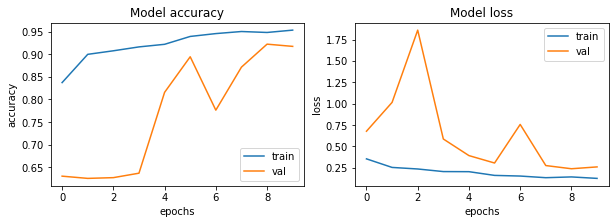

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

## Matríz de Confusión

In [15]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist.history['accuracy'][-1])*100, 2)))

CONFUSION MATRIX ------------------
[[194  40]
 [ 14 376]]

TEST METRICS ----------------------
Accuracy: 91.34615384615384%
Precision: 90.38461538461539%
Recall: 96.41025641025641%
F1-score: 93.30024813895783

TRAIN METRIC ----------------------
Train acc: 95.38


In [18]:
model.save('cnn_neumonia.h5')

### Ejecutar desde aca para cargar el modelo

In [19]:
model.load_weights("cnn_neumonia.h5")

In [20]:
preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist.history['accuracy'][-1])*100, 2)))

CONFUSION MATRIX ------------------
[[194  40]
 [ 14 376]]

TEST METRICS ----------------------
Accuracy: 91.34615384615384%
Precision: 90.38461538461539%
Recall: 96.41025641025641%
F1-score: 93.30024813895783

TRAIN METRIC ----------------------
Train acc: 95.38
